In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

import joblib
from utils.icm_framework_v2 import ICMFrameworkV2
from utils.reliability_visualizer import ReliabilityVisualizer

from utils.grace_classifier import GRACEClassifier

df_grace = pd.read_excel("dataset/data_validation.xlsx")



In [2]:

# Instantiate the classifier
grace_classifier = GRACEClassifier()

def make_prediction(row):
    return grace_classifier.predict(
        age=row['Idade'],
        heart_rate=row['FC_admissao'],
        systolic_bp=row['PAS_admissao'],
        creatinine=row['Creatininaadmissao'],
        killip_class=row['Killip_maximo'],
        cardiac_arrest=row['Killip_entrada'],
        st_deviation=row['STEMI'],
        elevated_markers=row['Troponin_admissao']
    )

# Apply predictions to the dataset
df_grace['Predicted'] = df_grace.apply(make_prediction, axis=1)


y_true = df_grace['Morte']
y_pred = df_grace['Predicted']

confusion_matrix(y_true, y_pred)

#[TN FP]
#[FN TP]


array([[60, 34],
       [ 7, 36]])

# Pointwise ICM

In [3]:
###########################################################
# Load Classifier and Data
###########################################################
pipeline = joblib.load('lr_pipeline_classifier.pkl')   # TODO: Just to make the data scaling 
training_data = pd.read_excel("dataset/data_train.xlsx")

y_train = training_data['Morte']
X_train = training_data.drop(columns=['Morte'])

X_train_preprocessed = pipeline.named_steps['preprocessor'].transform(X_train)

In [4]:
###########################################################
# Initialize ICM (Interpretable Confidence Measures)
###########################################################
##################3 
### Adjust
k_neighbors = 9  # Number of nearest neighbors
icm = ICMFrameworkV2(X_train_preprocessed, y_train.values, k_neighbors=k_neighbors)

In [5]:
###########################################################
# Classification and Reliability
###########################################################
def classify_and_calculate_reliability_icm(new_data, pipeline, icm):
    # Preprocess the data
    new_data_preprocessed = pipeline.named_steps['preprocessor'].transform(new_data)
    
    # Predict the label
    # predicted_label = pipeline.named_steps['classifier'].predict(new_data_preprocessed)[0]
    # Using grace

    new_data_row = new_data.iloc[0]  # Extract the first (and only) row


    predicted_label = grace_classifier.predict(
                        age=new_data_row['Idade'],
                        heart_rate=new_data_row['FC_admissao'],
                        systolic_bp=new_data_row['PAS_admissao'],
                        creatinine=new_data_row['Creatininaadmissao'],
                        killip_class=new_data_row['Killip_maximo'],
                        cardiac_arrest=new_data_row['Killip_entrada'],
                        st_deviation=new_data_row['STEMI'],
                        elevated_markers=new_data_row['Troponin_admissao']
                    )

    
    
    # Compute the reliability score
    reliability_score = icm.compute_confidence(new_data_preprocessed[0], predicted_label)
    
    return {
        "predicted_label": predicted_label,
        "reliability_score": reliability_score
    }

In [6]:
###########################################################
# Load and Test with Unseen Data
###########################################################
validation_data = pd.read_excel("dataset/data_validation.xlsx")
# first_500_instances = validation_data.iloc[:500]

results = []
# for _, instance in first_500_instances.iterrows():
for _, instance in validation_data.iterrows():
    true_label = instance['Morte']
    instance_df = pd.DataFrame([instance.drop(labels=['Morte'])])
    result = classify_and_calculate_reliability_icm(
        instance_df,
        pipeline,
        icm
    )
    result['true_label'] = true_label
    results.append(result)

results_df = pd.DataFrame(results)
# results_df

Sigma:
0.04495805621033169
Sigma:
0.03089367112681589
Sigma:
0.14152579419421035
Sigma:
0.004487906273471889
Sigma:
0.006297102656955596
Sigma:
0.0016233983320632585
Sigma:
0.026950181802945047
Sigma:
0.0033583575430897322
Sigma:
0.012713677739860655
Sigma:
0.005327966858015421
Sigma:
0.0027119204941623235
Sigma:
0.01357139076146758
Sigma:
0.015975066941023304
Sigma:
0.0033562588905192963
Sigma:
0.005012742179165687
Sigma:
0.22409699123223825
Sigma:
0.007345035931619918
Sigma:
0.009941338644594535
Sigma:
0.05006918082892136
Sigma:
0.0031257544003723335
Sigma:
0.019559048501770007
Sigma:
0.009528322526462926
Sigma:
0.003021349823477872
Sigma:
0.0026173390508618033
Sigma:
0.007330294930214302
Sigma:
0.0034709536153318
Sigma:
0.002263084218524625
Sigma:
0.11014315891852394
Sigma:
0.007088076895124354
Sigma:
0.11703327580351806
Sigma:
0.002378073502635841
Sigma:
0.003154590081252517
Sigma:
0.002814483288128809
Sigma:
0.02135150283372738
Sigma:
0.03819030775343355
Sigma:
0.00288107983189275

In [7]:
from sklearn.metrics import confusion_matrix
y_true = results_df['true_label']
y_pred = results_df['predicted_label']

confusion_matrix(y_true, y_pred)
#[TN FP]
#[FN TP]

array([[60, 34],
       [ 7, 36]])

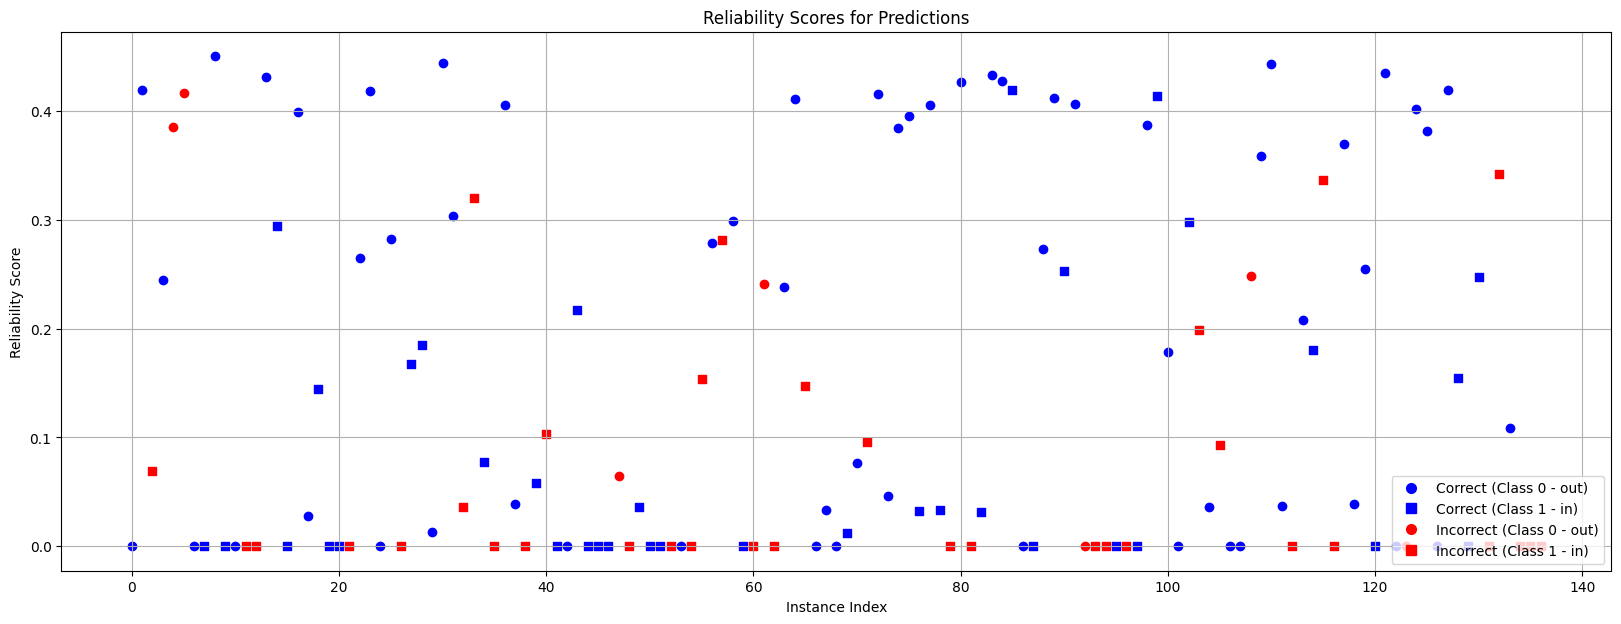

In [8]:
###########################################################
# Results
###########################################################
visualizer = ReliabilityVisualizer(results_df=results_df)

visualizer.plot_reliability_scores((20,7))

In [9]:
reliability_table_df = visualizer.get_reliability_table_5()

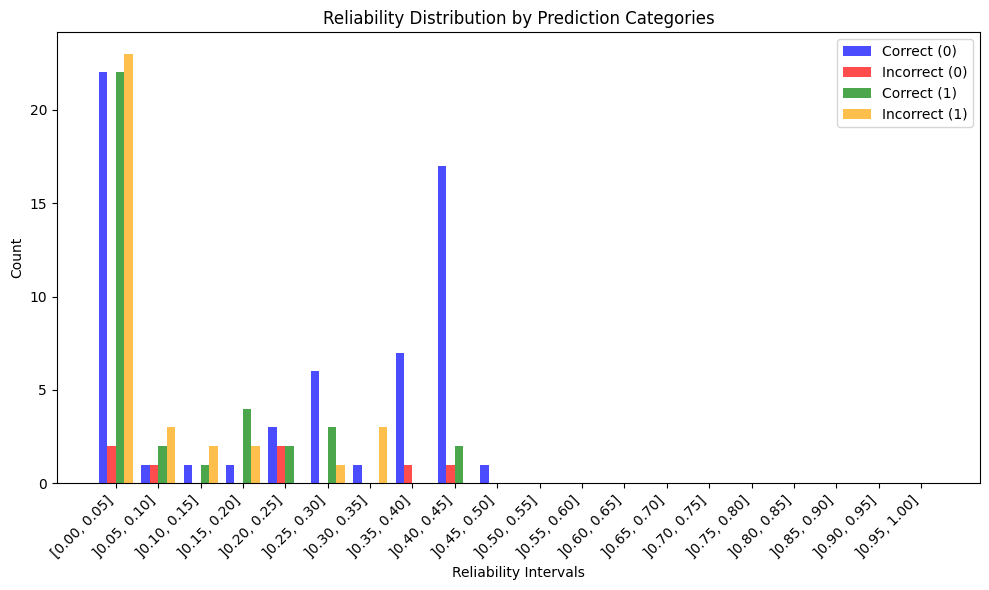

In [10]:
visualizer.plot_table_graph(reliability_table_df)

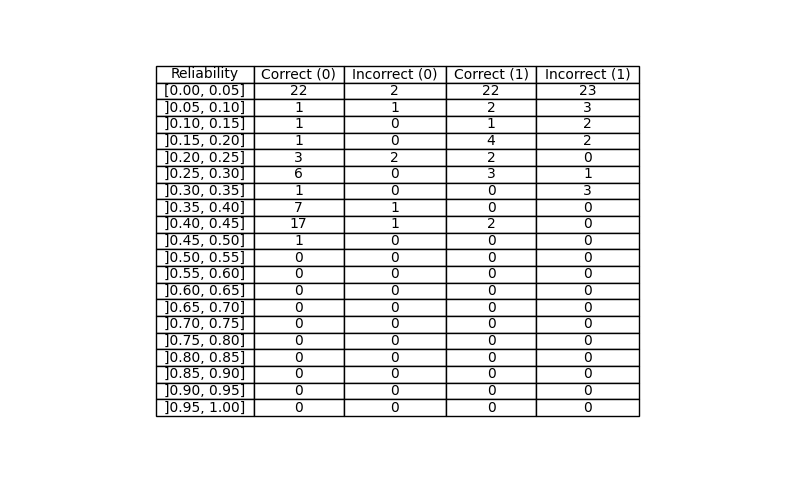

In [11]:
visualizer.plot_table_image(reliability_table_df)

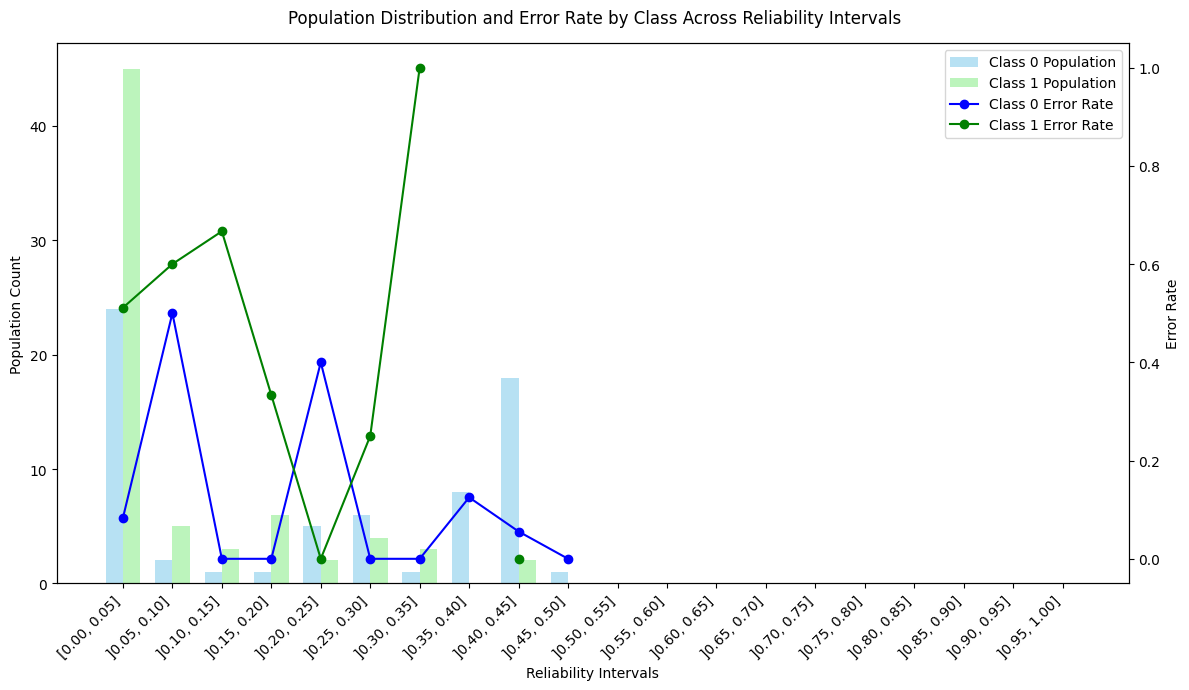

In [12]:
visualizer.plot_population_and_error_rate_by_class(reliability_table_df)

### 10

In [13]:
reliability_table_10_df = visualizer.get_reliability_table_10()
print(reliability_table_10_df)

    Reliability  Correct (0)  Incorrect (0)  Correct (1)  Incorrect (1)
0  [0.00, 0.10]           23              3           24             26
1  ]0.10, 0.20]            2              0            5              4
2  ]0.20, 0.30]            9              2            5              1
3  ]0.30, 0.40]            8              1            0              3
4  ]0.40, 0.50]           18              1            2              0
5  ]0.50, 0.60]            0              0            0              0
6  ]0.60, 0.70]            0              0            0              0
7  ]0.70, 0.80]            0              0            0              0
8  ]0.80, 0.90]            0              0            0              0
9  ]0.90, 1.00]            0              0            0              0


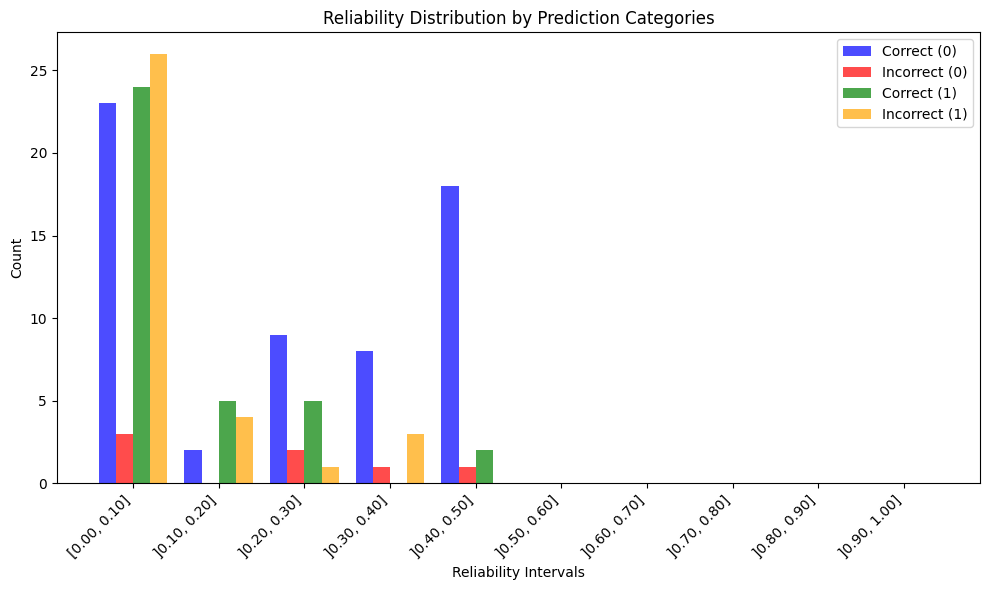

In [14]:
visualizer.plot_table_graph(reliability_table_10_df)

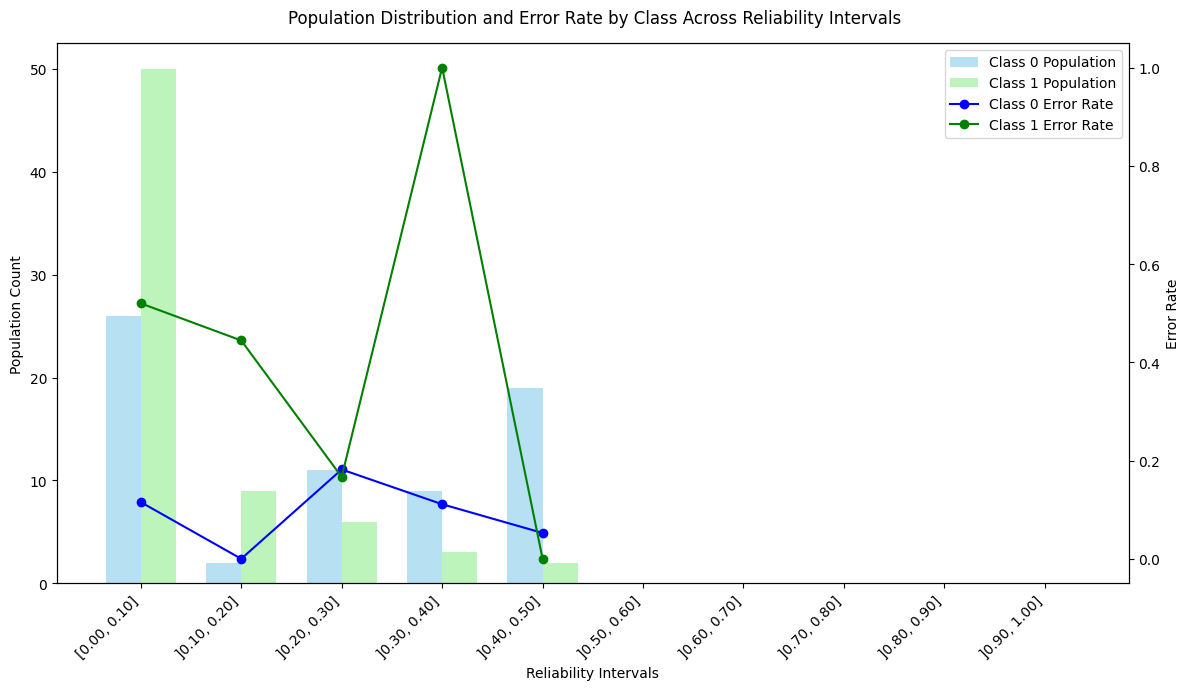

In [15]:
visualizer.plot_population_and_error_rate_by_class(reliability_table_10_df)

Sample reliability interval assignment:
   reliability_score reliability_interval
0           0.000000        (-0.001, 0.1]
1           0.419632           (0.4, 0.5]
2           0.069402        (-0.001, 0.1]
3           0.244495           (0.2, 0.3]
4           0.385451           (0.3, 0.4]
5           0.416751           (0.4, 0.5]
6           0.000000        (-0.001, 0.1]
7           0.000000        (-0.001, 0.1]
8           0.450383           (0.4, 0.5]
9           0.000000        (-0.001, 0.1]


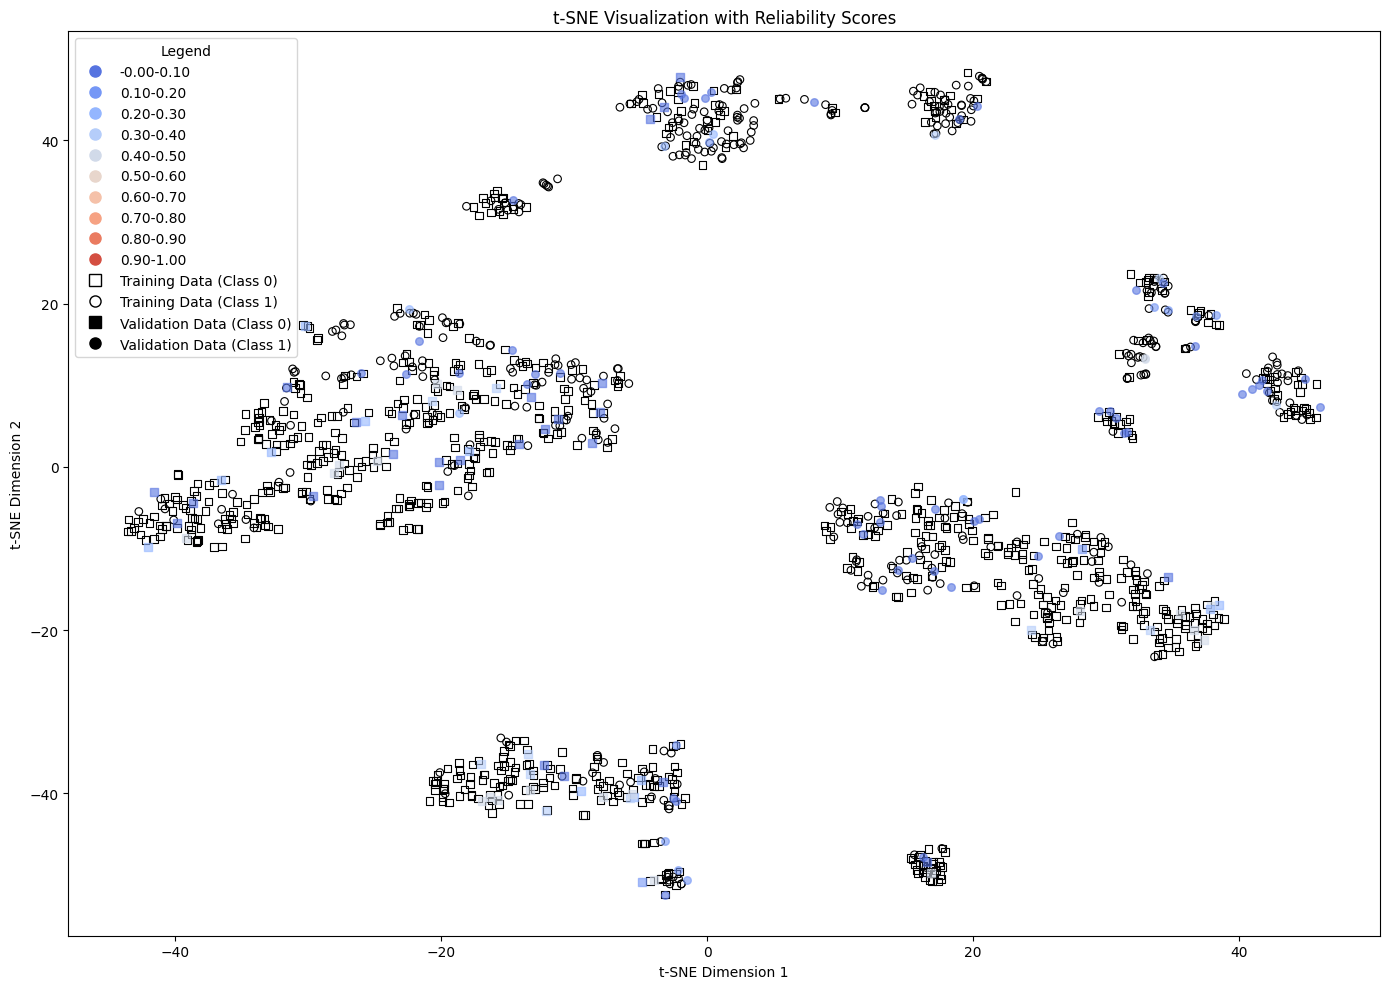

In [16]:
visualizer.plot_tsne_with_reliability(
    X_train_preprocessed, validation_data, y_train, pipeline
)